In [30]:
#Import dependencies and read in data


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ps
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from IPython.display import display
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score
from sklearn.datasets import make_classification
from collections import Counter
import pydotplus
import os
from IPython.display import Image
from transformers import pipeline
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

df = pd.read_csv("resources/diabetes_df.csv")
pd.options.display.max_columns = None
display(df)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [31]:
#checking Dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [32]:
#look at dataframe
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [33]:
#sort dataframe for diabetes_binary, highbp, highchol, cholcheck, bmi, smoker, stroke, heart deseaseor attack, physactivity, fruits, veggies, hvyalcoholcunsump, genhealth, menthealth, physhealth, diffwalk, sex, education
diabetes_df = df[['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education']]
diabetes_df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0


In [34]:
#0= no
#1= yes
diabetes_df['Diabetes_binary'].value_counts()

Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

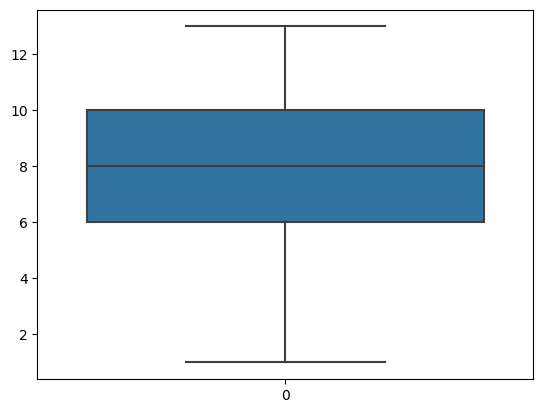

In [35]:
#Histogram of Age
sns.boxplot(diabetes_df['Age'])
plt.show

In [36]:
#count null values
diabetes_df.isnull().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
dtype: int64

In [37]:
scaler = RobustScaler()
diabetes_df['BMI'] = pd.DataFrame(scaler.fit_transform(diabetes_df[['BMI']]))
diabetes_df

/var/folders/tz/nqby0pvn6llfbd7c3rtk0k280000gn/T/ipykernel_66003/4193381810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetes_df['BMI'] = pd.DataFrame(scaler.fit_transform(diabetes_df[['BMI']]))


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education
0,0.0,1.0,1.0,1.0,1.857143,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0
1,0.0,0.0,0.0,0.0,-0.285714,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0
2,0.0,1.0,1.0,1.0,0.142857,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0
3,0.0,1.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0
4,0.0,1.0,1.0,1.0,-0.428571,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,2.571429,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0
253676,1.0,1.0,1.0,1.0,-1.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0
253677,0.0,0.0,0.0,1.0,0.142857,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0
253678,0.0,1.0,0.0,1.0,-0.571429,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0


In [38]:
# Split training and testing sets
# Create the features DataFrame, X
X = diabetes_df.copy()
X = X.drop(columns='Diabetes_binary')

# Create the target DataFrame, y
y = diabetes_df['Diabetes_binary']

# Use train_test_split to separate the data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [39]:
# Create an undersampler
rus = RandomUnderSampler(random_state=42)

In [40]:
# Fit and transform the data to create a balanced dataset
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [41]:
# Check the class distribution after undersampling
print(f"Resampled class distribution: {Counter(y_resampled)}")

Resampled class distribution: Counter({0.0: 26562, 1.0: 26562})


In [42]:
# Create a `LogisticRegression` function and assign it 
# to a variable named `logistic_regression_model`.
logistic_regression_model = LogisticRegression()

In [43]:
# Fit the model
logistic_regression_model.fit(X_resampled, y_resampled)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [44]:
# Apply the fitted model to the `test` dataset
testing_predictions = logistic_regression_model.predict(X_test)

# Save both the test predictions and actual test values to a DataFrame
results_df = pd.DataFrame({
    "Testing Data Predictions": testing_predictions, 
    "Testing Data Actual Targets": y_test})

# Calculate the model's accuracy on the test dataset
accuracy_score(y_test, testing_predictions)

0.7279091769157995

In [45]:
# Apply the fitted model to the `test` dataset
testing_predictions = logistic_regression_model.predict(X_test)

# Save both the test predictions and actual test values to a DataFrame
results_df = pd.DataFrame({
    "Testing Data Predictions": testing_predictions, 
    "Testing Data Actual Targets": y_test})

# Calculate the model's accuracy on the test dataset
accuracy_score(y_test, testing_predictions)

0.7279091769157995

In [46]:
# Create a confusion matrix
print(confusion_matrix(y_test,testing_predictions, labels=[1,0]))

[[ 6772  2012]
 [15244 39392]]


In [47]:
# Create a classification report
print(classification_report(y_test, testing_predictions, labels = [1, 0]))
#logistics regression utilizing robust scaler on BMI higher recall focuses on finding false negitives 

              precision    recall  f1-score   support

           1       0.31      0.77      0.44      8784
           0       0.95      0.72      0.82     54636

    accuracy                           0.73     63420
   macro avg       0.63      0.75      0.63     63420
weighted avg       0.86      0.73      0.77     63420



In [48]:
#ATTEMPT TO CODE NUERAL NETWORK

# Scale BMI
scaler = RobustScaler()
diabetes_df['BMI'] = scaler.fit_transform(diabetes_df[['BMI']])

# Split the data into features (X) and target (y)
X = diabetes_df.drop(columns='Diabetes_binary')
y = diabetes_df['Diabetes_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Undersample to create a balanced dataset
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
print(f"Resampled class distribution: {Counter(y_resampled)}")

Resampled class distribution: Counter({0.0: 28349, 1.0: 28349})


/var/folders/tz/nqby0pvn6llfbd7c3rtk0k280000gn/T/ipykernel_66003/1452167375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetes_df['BMI'] = scaler.fit_transform(diabetes_df[['BMI']])


In [49]:
# Build a Sequential model
model = Sequential()

# Input layer and first hidden layer with 16 neurons
model.add(Dense(16, input_shape=(X_resampled.shape[1],), activation='relu'))

# Add another hidden layer
model.add(Dense(8, activation='relu'))

# Output layer (since this is binary classification, use sigmoid activation)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
# Train the model
history = model.fit(X_resampled, y_resampled, 
                    validation_data=(X_test, y_test), 
                    epochs=50, 
                    batch_size=32)

Epoch 1/50
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - accuracy: 0.6553 - loss: 0.6360 - val_accuracy: 0.7338 - val_loss: 0.5079
Epoch 2/50
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step - accuracy: 0.7394 - loss: 0.5243 - val_accuracy: 0.6907 - val_loss: 0.5585
Epoch 3/50
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step - accuracy: 0.7435 - loss: 0.5170 - val_accuracy: 0.7169 - val_loss: 0.5211
Epoch 4/50
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 1s 396us/step - accuracy: 0.7424 - loss: 0.5167 - val_accuracy: 0.7006 - val_loss: 0.5530
Epoch 5/50
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 1s 405us/step - accuracy: 0.7454 - loss: 0.5137 - val_accuracy: 0.7007 - val_loss: 0.5406
Epoch 6/50
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - accuracy: 0.7461 - loss: 0.5117 - val_accuracy: 0.7080 - val_loss: 0.5264
Epoch 7/50
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step - accuracy: 0.7454 - loss: 0.5111 - val_accuracy: 0.7086 - val_loss: 0.5233
Epoch 8/50
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step - accuracy: 0.7457 -

In [52]:
# Make predictions on the test set
testing_predictions = (model.predict(X_test) > 0.5).astype("int32")

# Calculate accuracy
test_accuracy = accuracy_score(y_test, testing_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, testing_predictions, labels=[1, 0])
print(f'Confusion Matrix:\n{conf_matrix}')

# Classification report
class_report = classification_report(y_test, testing_predictions, labels=[1, 0])
print(f'Classification Report:\n{class_report}')

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step
Test Accuracy: 0.7004
Confusion Matrix:
[[ 5813  1184]
 [14019 29720]]
Classification Report:
              precision    recall  f1-score   support

           1       0.29      0.83      0.43      6997
           0       0.96      0.68      0.80     43739

    accuracy                           0.70     50736
   macro avg       0.63      0.76      0.61     50736
weighted avg       0.87      0.70      0.75     50736

